In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
import json
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random
from IPython.display import Image as displayImage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

#### Functions of generating training data

In [2]:
img_size = 28

def create_ring(image_size, center, radius, thickness, deformation=0):
    img = Image.new('L', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)
    
    for angle in range(360):
        r = radius + random.uniform(-deformation, deformation)
        x = center[0] + r * np.cos(np.radians(angle))
        y = center[1] + r * np.sin(np.radians(angle))
        draw.ellipse([x-thickness/2, y-thickness/2, x+thickness/2, y+thickness/2], fill=255)
    
    return np.array(img)

def generate_dataset(num_images, image_size=img_size, save_dir='ring_generator_dataset'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    labels = []
    
    for i in range(num_images):
        center = (random.randint(5, image_size-5), random.randint(5, image_size-5))
        radius = random.randint(4, min(center[0], center[1], image_size-center[0], image_size-center[1])-1)
        thickness = random.uniform(0.2, 1.5)#*np.sqrt(radius)
        deformation = random.uniform(0.5, 3)
        
        img = create_ring(image_size, center, radius, thickness, deformation)
        
        img_pil = Image.fromarray(img)
        img_pil.save(f'{save_dir}/ring_image_{i}.png')
        
        # Store the ring properties as a label, now including radius
        label = {
            "center": center,
            "radius": radius,
            "thickness": thickness,
            "deformation": deformation
        }
        labels.append(label)
    
    # Save labels as JSON
    with open(f'{save_dir}/labels.json', 'w') as f:
        json.dump(labels, f, indent=2)

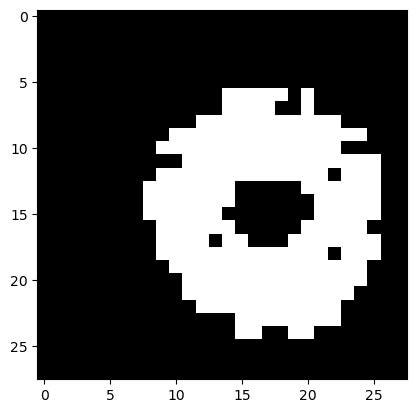

In [201]:
fig = create_ring(28, [17.4, 15.4], 6.2, 0.42, 2.70)
plt.imshow(fig, cmap="gray")

#### Functions of loading dataset

In [3]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [5]:
class myDatasetLoader(DataLoader):
    def __init__(self, image, label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        data  = self.image[idx]
        lb    = self.label[idx]
        data  = torch.tensor(data[np.newaxis, ...], dtype=torch.float32)
        lb = torch.tensor(lb, dtype=torch.float32)
        
        return data, lb

#### Functions of conditional VAE

In [215]:
# Hyperparameters
image_channels = 1   # Grayscale images
image_size = 28      # 28x28 images
latent_dim = 20      # Dimension of the latent space
label_dim = 5        # Dimension of the label space
label_up_dim = 50    # Increased dimension of the label space
batch_size = 128
learning_rate = 1e-3
num_epochs = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConditionalConvVAE(nn.Module):
    def __init__(self, image_channels=1, latent_dim=20, label_dim=5):
        super(ConditionalConvVAE, self).__init__()
        
        # Embedding layer for labels
        self.label_embed = nn.Linear(label_dim, label_up_dim)  # Project label to a higher dimension
        
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels + label_up_dim, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),                   # [batch, 64, 7, 7]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),                  # [batch, 128, 3, 3]
            nn.ReLU(),
            nn.Flatten(),                                                            # [batch, 1152]
        )
        
        # Latent space
        self.fc_mu = nn.Linear(128 * 3 * 3 + label_up_dim, latent_dim)        # Mean of latent space
        self.fc_logvar = nn.Linear(128 * 3 * 3 + label_up_dim, latent_dim)    # Log variance of latent space
        
        # Decoder: Fully connected layer followed by transposed convolutions
        self.fc_decode = nn.Linear(latent_dim + label_up_dim, 128 * 7 * 7)    # Start from a bigger dimension for transposed convs
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # [batch, 64, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # [batch, 32, 28, 28]
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1, padding=1),  # [batch, 1, 28, 28]
            nn.Sigmoid()  # Output pixel values in [0, 1]
        )
    
    def encode(self, x, labels):
        labels_embedded = self.label_embed(labels)
        
        # Expand labels to match input dimensions and concatenate along the channel dimension
        labels_expanded = labels_embedded.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        # print(labels_expanded.shape)
        x = torch.cat([x, labels_expanded], dim=1)  # Concatenate labels along the channel dimension
        # print(x.shape)
        
        h = self.encoder(x)
        h = torch.cat([h, labels_embedded], dim=1)  # Concatenate flattened conv output and labels
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        z = mu + eps * std  # Reparameterization trick
        return z
    
    def decode(self, z, labels):
        labels_embedded = self.label_embed(labels)
        z = torch.cat([z, labels_embedded], dim=1)  # Concatenate z and embedded labels
        
        h = self.fc_decode(z)
        h = h.view(-1, 128, 7, 7)  # Reshape to fit into the transposed convolutions
        x_recon = self.decoder(h)
        return x_recon
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar, z

In [194]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE)
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return bce_loss + kl_loss

#### Functions of inference

In [187]:
def generate_ring_images(generator, labels, latent_var):
    generator.eval()
    labels = torch.tensor(labels, dtype=torch.float32).to(device)
    latent_var = torch.tensor(latent_var, dtype=torch.float32).to(device)
    fig_ge =  generator.decode(latent_var, labels)
    # print(fig_ge.shape)
    fig_ge = fig_ge[:,0,:,:].cpu().detach().numpy()
    return fig_ge

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

def plot_generated_rings(generator, labels, num_samples=5, max_cols=4, seed=10, savepath=None):
    num_samples = min(num_samples, len(labels))
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    figsize = (num_cols * 3, num_rows * 3.8)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Randomly select indices
    if num_samples < len(labels):
        np.random.seed(seed)
        random_indices = np.random.choice(len(labels), num_samples, replace=False)
        selected_labels = labels[random_indices]
    else:
        selected_labels = torch.clone(labels)
        
    latent_var = np.random.rand(num_samples, latent_dim)
    
    generated_images = generate_ring_images(generator, selected_labels, latent_var)
    img_size = generated_images.shape[1]
    # print(generated_images.shape)
    
    for i in range(num_samples):
        ax = axes[i]
        img = generated_images[i]
        ax.imshow(img, cmap='gray')
        
        center_x, center_y, radius, thickness, deformation = selected_labels[i]
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        ax.text(0.05, 1.18, f"Center: ({center_x:.1f}, {center_y:.1f})\n"
                           f"Radius: {radius:.1f}\n"
                           f"Thickness: {thickness:.2f}\n"
                           f"Deformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=8)
        
        ax.axis('off')
    
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, format="png", dpi=400)
    plt.show()

### Generate dataset

In [3]:
# Generate 10 images (for this project having a lot of images actually makes a difference!)
generate_dataset(5000)
print("Dataset generated successfully!")

Dataset generated successfully!


### Load total dataset and divide them into training and validation sets

In [10]:
images, labels = load_single_ring_dataset('ring_generator_dataset')

In [210]:
total_ratio = 0.375
train_ratio = 0.8

if total_ratio < 1:
    np.random.seed(9999)
    num_tot_samples = int(total_ratio*len(images))
    choose_indice = np.random.choice(len(images), num_tot_samples, replace=False)
    mydataset = myDatasetLoader(images[choose_indice], labels[choose_indice])
else:
    mydataset = myDatasetLoader(images, labels)
    
print(f"Load {len(mydataset):d} samples.")

train_size = int(train_ratio*len(mydataset))
val_size = len(mydataset) - train_size
train_dataset, val_dataset = random_split(mydataset, [train_size, val_size])

dataloader = DataLoader(mydataset, batch_size=batch_size, drop_last=True, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

Load 1875 samples.


In [209]:
1875/5000

0.375

In [216]:
# Initialize model, optimizer, and loss function
cvae = ConditionalConvVAE(image_channels=image_channels, latent_dim=latent_dim, label_dim=label_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# # Training loop
# cvae.train()
# train_loss_list = []
# for epoch in range(num_epochs):
#     train_loss = 0
#     for batch_idx, (idata, ilabel) in enumerate(dataloader):
#         idata, ilabel = idata.to(device), ilabel.to(device)
        
#         optimizer.zero_grad()
#         recon_batch, mu, logvar, _ = cvae(idata, ilabel)
#         loss = vae_loss(recon_batch, idata, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#     train_loss_list.append(train_loss)
    
#     print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset):.4f}')

# cvae = ConditionalConvVAE(image_channels=image_channels, latent_dim=latent_dim, label_dim=label_dim).to(device)
# optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Training loop
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0
    cvae.train()
    for batch_idx, (idata, ilabel) in enumerate(train_loader):
        idata, ilabel = idata.to(device), ilabel.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = cvae(idata, ilabel)
        loss = vae_loss(recon_batch, idata, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    val_loss = 0
    cvae.eval()
    with torch.no_grad():
        for batch_idx, (idata, ilabel) in enumerate(val_loader):
            idata, ilabel = idata.to(device), ilabel.to(device)

            recon_batch, mu, logvar, _ = cvae(idata, ilabel)
            loss = vae_loss(recon_batch, idata, mu, logvar)
            val_loss += loss.item()
        
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader.dataset):.4f} Val Loss: {val_loss / len(val_loader.dataset):.4f}')

Epoch 1, Train Loss: 484.6080 Val Loss: 299.4458
Epoch 2, Train Loss: 374.6462 Val Loss: 258.5112
Epoch 3, Train Loss: 339.5993 Val Loss: 235.2476
Epoch 4, Train Loss: 313.1896 Val Loss: 214.8696
Epoch 5, Train Loss: 280.4249 Val Loss: 191.8278
Epoch 6, Train Loss: 248.6486 Val Loss: 172.4202
Epoch 7, Train Loss: 228.6181 Val Loss: 162.8520
Epoch 8, Train Loss: 213.5017 Val Loss: 152.0206
Epoch 9, Train Loss: 200.7925 Val Loss: 143.0702
Epoch 10, Train Loss: 191.3989 Val Loss: 136.6476
Epoch 11, Train Loss: 180.9783 Val Loss: 128.3334
Epoch 12, Train Loss: 173.8338 Val Loss: 125.4854
Epoch 13, Train Loss: 169.0623 Val Loss: 125.0748
Epoch 14, Train Loss: 162.4049 Val Loss: 115.9244
Epoch 15, Train Loss: 152.2959 Val Loss: 106.5407
Epoch 16, Train Loss: 137.6774 Val Loss: 94.9838
Epoch 17, Train Loss: 134.5575 Val Loss: 94.2906
Epoch 18, Train Loss: 128.9359 Val Loss: 86.1894
Epoch 19, Train Loss: 112.0791 Val Loss: 78.9025
Epoch 20, Train Loss: 104.7546 Val Loss: 71.2436
Epoch 21, Trai

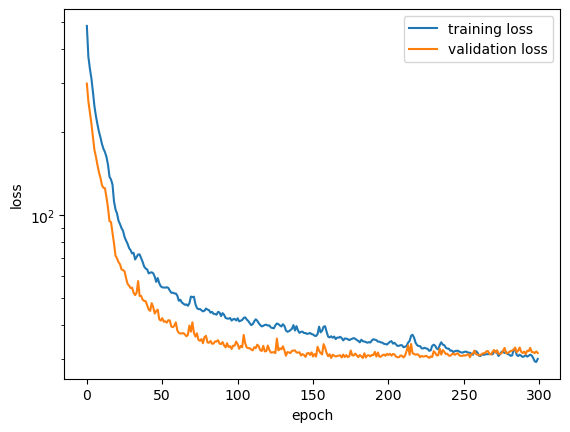

In [221]:
plt.plot(np.array(train_loss_list)/len(train_loader.dataset), label="training loss")
plt.plot(np.array(val_loss_list)/len(val_loader.dataset), label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.legend()

In [164]:
# save the model parameters
savepath = f"./cvae_params_{len(train_loader.dataset):d}.pkl"
torch.save(cvae.state_dict(), savepath)

In [20]:
# Set model to evaluation mode
cvae.eval()

# Example to get latent variables for a sample batch
with torch.no_grad():
    sample_data, sample_labels = next(iter(dataloader))
    sample_data, sample_labels = sample_data.to(device), sample_labels.to(device)
    mu, logvar = cvae.encode(sample_data, sample_labels)
    z = cvae.reparameterize(mu, logvar)  # Latent variables
    figs = cvae.decode(z, sample_labels)
    
    # print(f'Latent Variables Shape: {z.shape}')  # Should be [batch_size, latent_dim]
    # print(z)  # Output latent variables

In [81]:
figs = figs[:,0,:,:].cpu().detach().numpy()

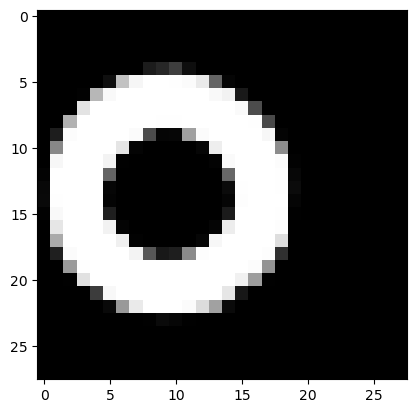

tensor([0.3571, 0.5000, 0.2500, 0.8975, 1.4375], device='cuda:0')


In [76]:
plt.imshow(figs[0], cmap="gray")
plt.show()
print(sample_labels[0])

tensor([[0.2092, 0.4861, 0.9817, 0.2100, 0.6710, 0.9201, 0.5441, 0.8052, 0.6047,
         0.1155, 0.7879, 0.2481, 0.2368, 0.3730, 0.2047, 0.2177, 0.3065, 0.1443,
         0.1571, 0.5417]], device='cuda:0')
tensor([[0.3214, 0.6429, 0.2857, 0.7943, 2.2858]], device='cuda:0')


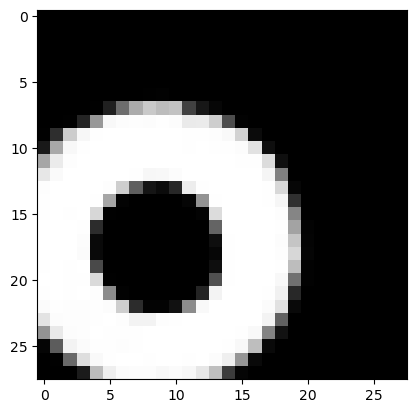

In [106]:
z_ge = torch.rand(1,20).to(device)
print(z_ge)
fig_ge = cvae.decode(z_ge, sample_labels[:1,:])
print(sample_labels[:1,:])
fig_ge = fig_ge[0,0,:,:].cpu().detach().numpy()
plt.imshow(fig_ge, cmap="gray")

### Inference

In [213]:
sample_data, sample_labels = next(iter(dataloader))
sample_data, sample_labels = sample_data.to(device), sample_labels.to(device)

label_maxs = torch.max(sample_labels, axis=0)
label_mins = torch.min(sample_labels, axis=0)

torch.manual_seed(4321)
num_samples = 100
val_sample_labels = torch.rand(num_samples, label_dim).to(device)#*(label_maxs.values-label_mins.values) + label_mins.values

/tmp/ipykernel_3753157/1059802379.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


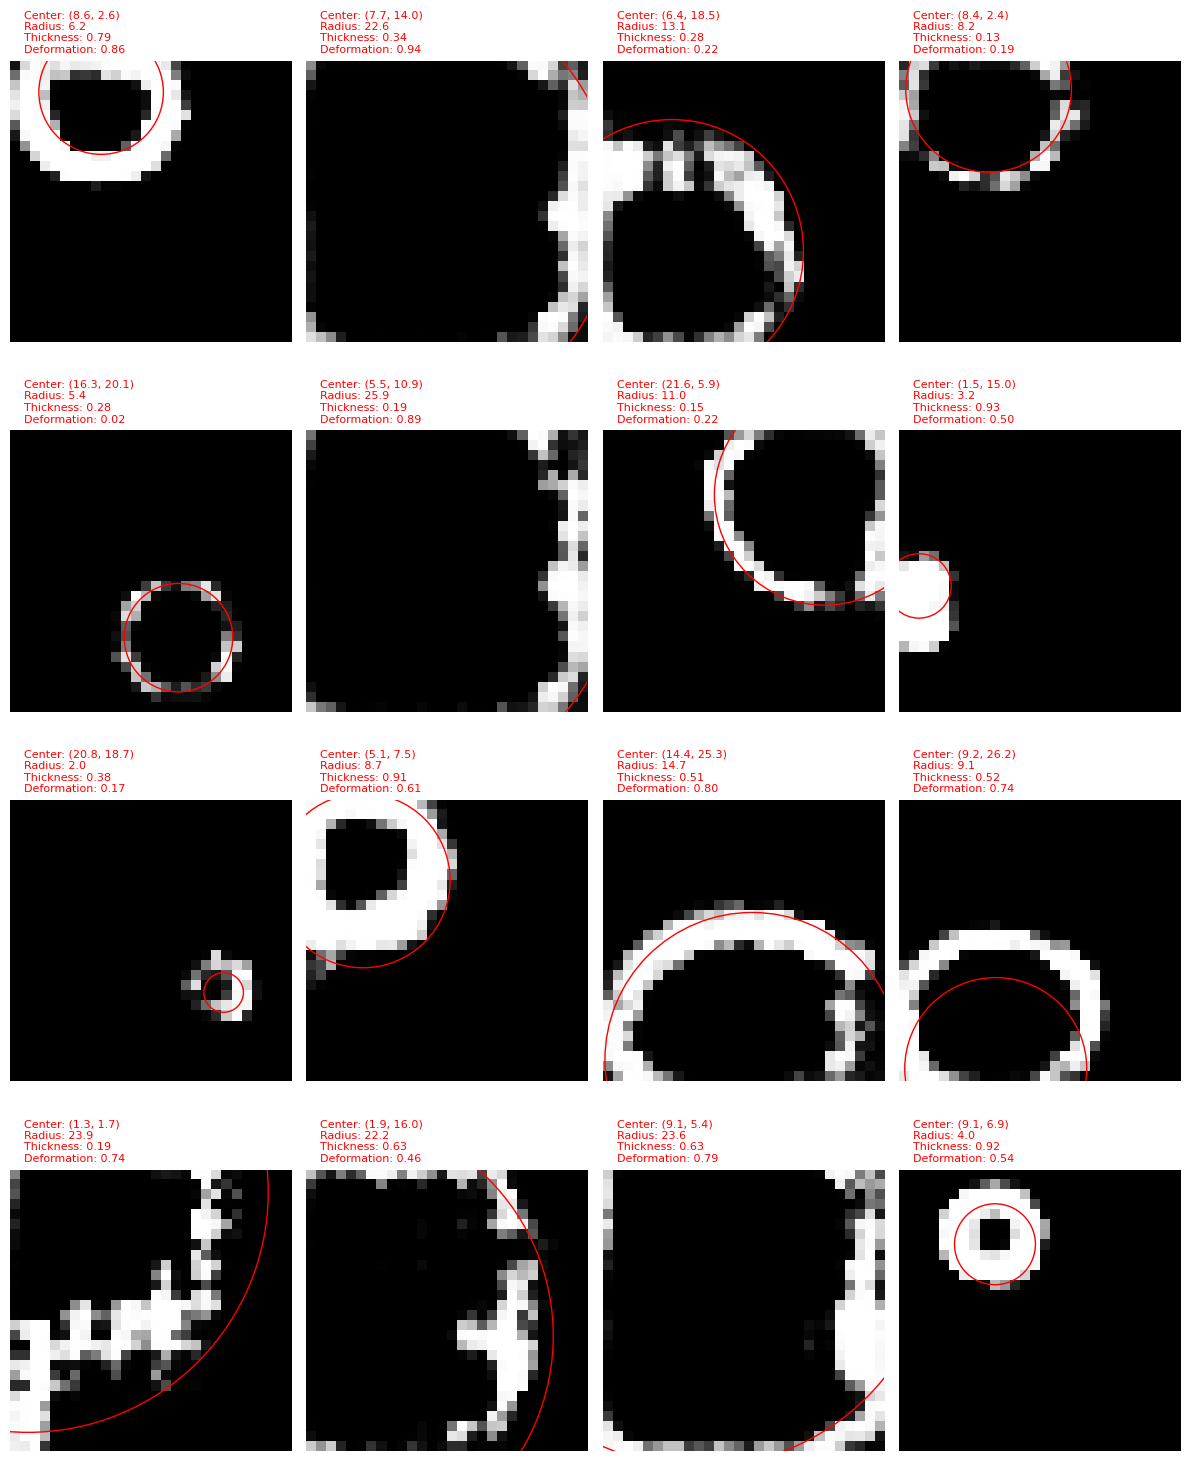

In [219]:
plot_generated_rings(cvae, val_sample_labels, num_samples=16, seed=1, savepath=None)

/tmp/ipykernel_3753157/104014526.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


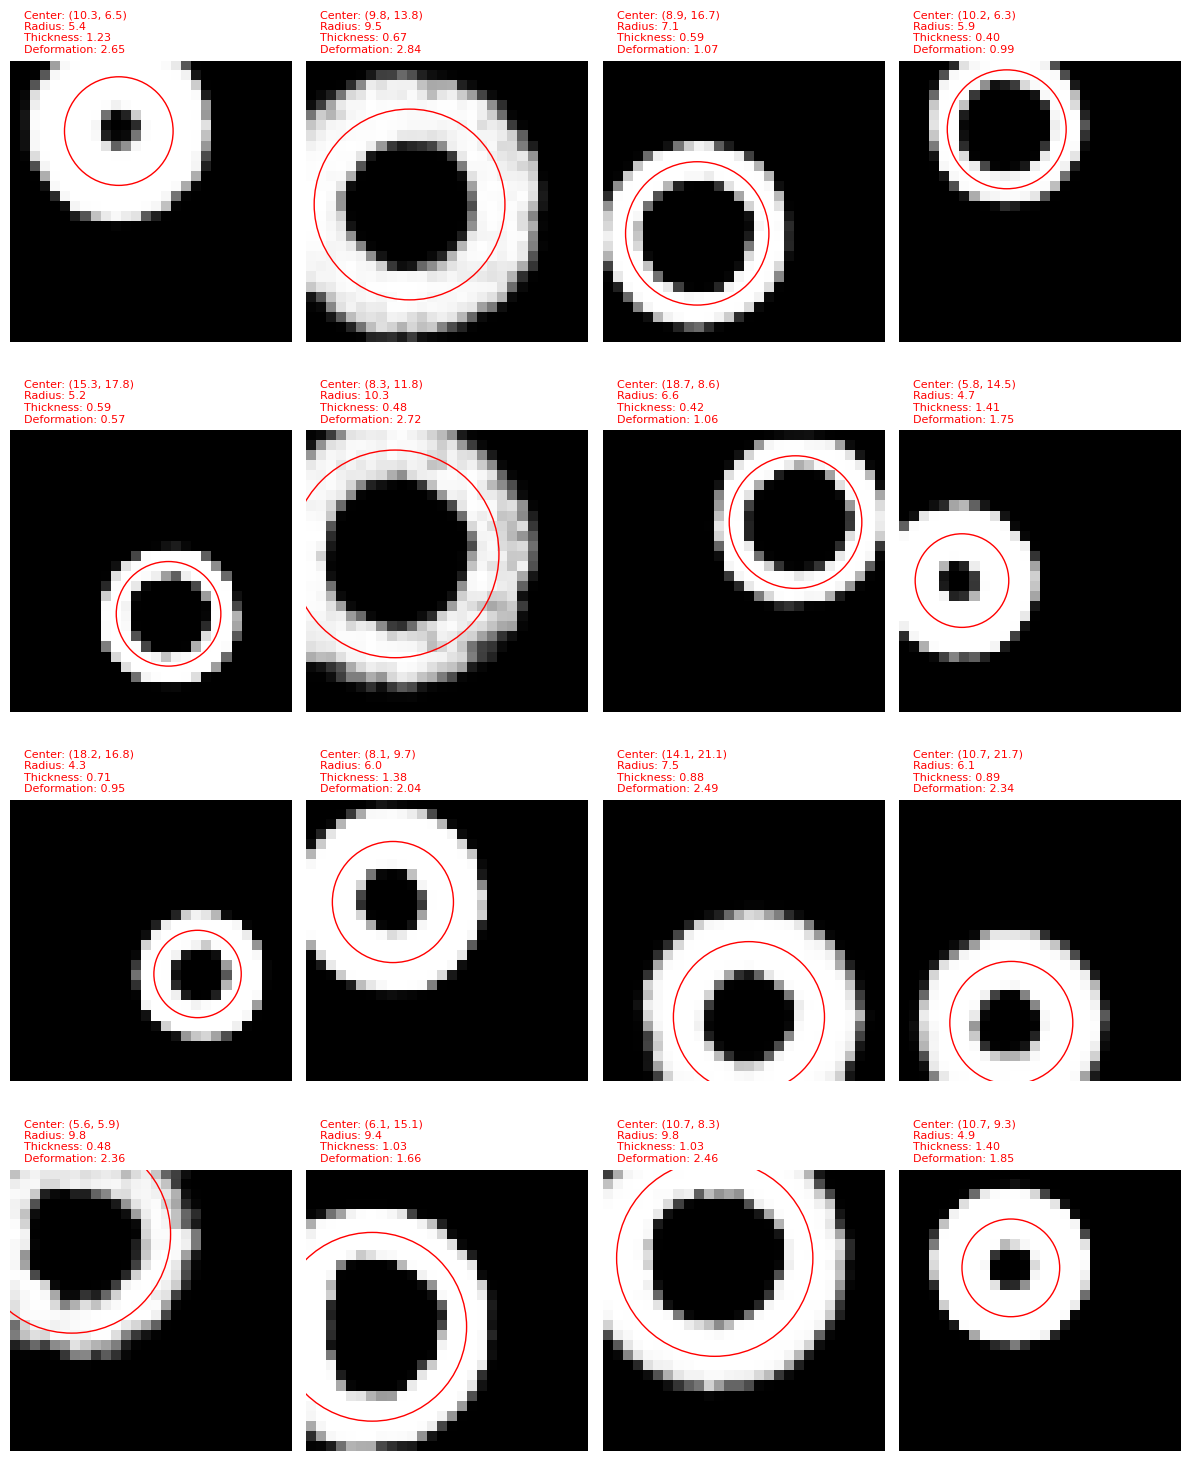

In [28]:
plot_generated_rings(cvae, val_sample_labels, num_samples=16, seed=1)

In [55]:
fid_sample_label = val_sample_labels[5]

/tmp/ipykernel_3753157/104014526.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


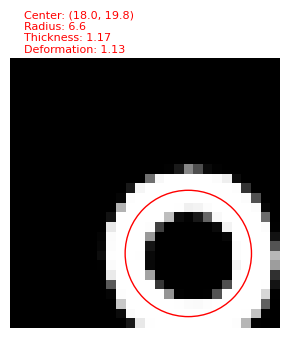

In [56]:
plot_generated_rings(cvae, fid_sample_label.unsqueeze(0), num_samples=1, seed=1)

In [111]:
move_xctr_sample_label = torch.cat((torch.linspace(label_mins.values[0], label_maxs.values[0], 4).unsqueeze(1).to(device), 
                                   fid_sample_label.repeat(4,1)[:,1:]), 1)

/tmp/ipykernel_3753157/2064389748.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


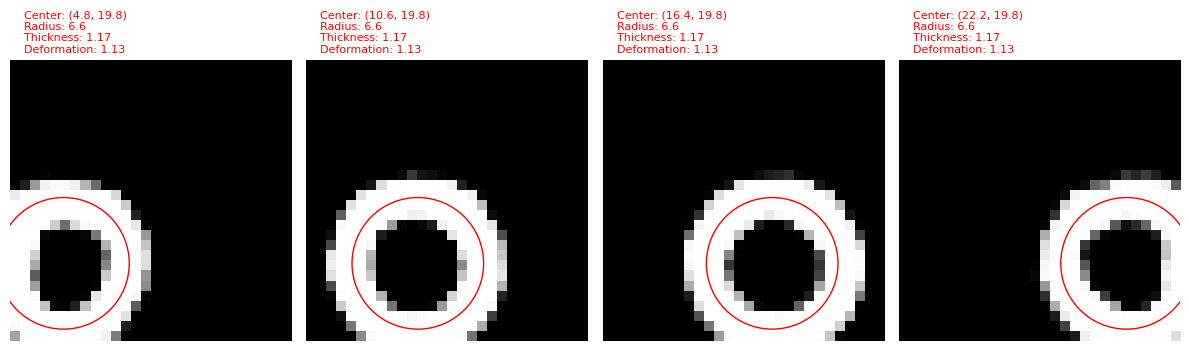

tensor([[0.1786, 0.7322, 0.2426, 1.1742, 1.1285],
        [0.3929, 0.7322, 0.2426, 1.1742, 1.1285],
        [0.6071, 0.7322, 0.2426, 1.1742, 1.1285],
        [0.8214, 0.7322, 0.2426, 1.1742, 1.1285]], device='cuda:0')


In [119]:
plot_generated_rings(cvae, move_xctr_sample_label, num_samples=4, seed=1)

In [143]:
tmp = move_xctr_sample_label.cpu().detach().numpy()
move_xctr_img_list = []
for (x, y, r, th, de) in tmp:
    move_xctr_img_list.append(create_ring(img_size, np.array([x,y])*img_size, r*img_size, th, de))
move_xctr_img_list = np.asarray(move_xctr_img_list)

In [146]:
move_xctr_dataset = myDatasetLoader(move_xctr_img_list, move_xctr_sample_label)
move_xctr_dataloader = DataLoader(move_xctr_dataset, batch_size=batch_size)

In [147]:
cvae.eval()
with torch.no_grad():
    for batch_idx, (idata, ilabel) in enumerate(move_xctr_dataloader):
        idata, ilabel = idata.to(device), ilabel.to(device)

        mu, logvar = cvae.encode(idata, ilabel)

/tmp/ipykernel_3753157/1504706648.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lb = torch.tensor(lb, dtype=torch.float32)


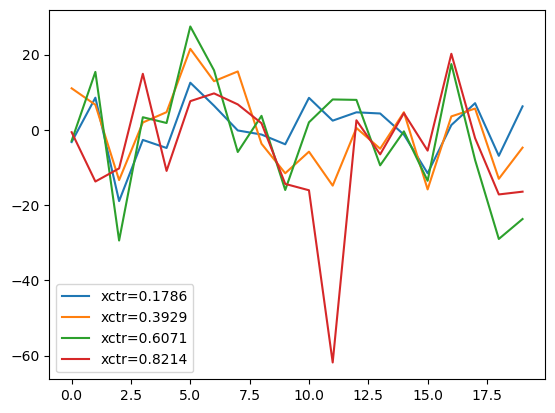

In [157]:
for (xctr, imu) in zip(move_xctr_sample_label[:,0], mu):
    plt.plot(np.arange(len(imu)), imu.cpu(), label=f"xctr={xctr:.4f}")

plt.legend()